In [1]:
%load_ext autoreload
%autoreload 2

There're a few ways to do this:
- during past consolidation, explicitly contrast away the past points.
- Find some other measures for OOD detection using the whole cluster!

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial

In [3]:
def plot_data(data_dict, ax=None):
    cmap = "coolwarm"
    od_color = "black"

    # Use the provided ax or create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()

    # Plot anchor points colored by class labels
    if "anchor" in data_dict:
        anchor_X, anchor_y = data_dict["anchor"]
        ax.scatter(anchor_X[:, 0], anchor_X[:, 1], c=anchor_y, cmap=cmap, label="Anchor")

    if "ID" in data_dict:
        id_X, id_y = data_dict["ID"]
        # Plot in-distribution (ID) data points with lighter color
        ax.scatter(id_X[:, 0], id_X[:, 1], c=id_y, cmap=cmap, alpha=0.5, label="In-Distribution")

    if "OD" in data_dict:
        od_X, od_y = data_dict["OD"]
        # Plot OD data points with distinct color
        ax.scatter(od_X[:, 0], od_X[:, 1], c=od_color, label="Out-of-Distribution")

    ax.legend()

    # Only call plt.show() if ax was not provided
    if ax is None:
        plt.show()

In [4]:
def apply_transform_to_data_dict(data_dict, transform=None):
    """
    Applies a transformation function to the X component of each dataset in the data_dict.

    :param data_dict: Dictionary containing datasets. Each key corresponds to a dataset name,
                      and each value is a tuple (X, y) where X is the data to transform.
    :param transform: A function that applies a transformation to X.
    :return: A new data_dict with transformed X components.
    """
    transformed_data_dict = {}
    if transform is None:
        transform = lambda x: x

    for key, (X, y) in data_dict.items():
        # Apply the transform function to X
        transformed_X = transform(X)

        # Update the dataset in the new dictionary
        transformed_data_dict[key] = (transformed_X, y)

    return transformed_data_dict

In [5]:
@torch.inference_mode()
def contrastive_transform(net, task, X):
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
    X = X.to(net.device)
    return net.contrastive_embedding(X, task).detach().cpu().numpy()

In [6]:
def combined_tsne_transform(data_dict, n_components=2, random_state=42):
    """
    Applies t-SNE to reduce the dimensions of the combined image data from all subsets
    (OD, ID, anchor) to ensure they are mapped to the same space.

    :param data_dict: Dictionary containing OD, ID, and anchor datasets.
                      Each value should be a tuple (X, y).
    :param n_components: The number of dimensions to reduce to (default is 2).
    :param random_state: Random state for reproducibility (optional).
    :return: Dictionary with transformed data for each subset.
    """
    # Combine all subsets into one dataset for fitting t-SNE
    combined_X = np.concatenate([X.reshape(X.shape[0], -1) for X, _ in data_dict.values()], axis=0)

    # Fit t-SNE on the combined dataset
    tsne = TSNE(n_components=n_components, random_state=random_state)
    combined_X_transformed = tsne.fit_transform(combined_X)

    # Split the transformed data back into the respective subsets
    transformed_data_dict = {}
    start_idx = 0
    for key, (X, y) in data_dict.items():
        end_idx = start_idx + X.shape[0]
        transformed_data_dict[key] = (combined_X_transformed[start_idx:end_idx, :], y)
        start_idx = end_idx

    return transformed_data_dict

In [7]:
import matplotlib.pyplot as plt

def plot_scores_box(data_dict, computer, ax=None):
    """
    Produces a box plot for the given data_dict, representing the full distribution of scores.
    :param data_dict: Dictionary with keys 'anchor', 'ID', and 'OD'.
    :param computer: Function that computes the scores.
    :param ax: Optional matplotlib axes object.
    """
    scores_dict = {}

    # Compute scores
    for key, (X, y) in data_dict.items():
        scores = computer(X)
        scores_dict[key] = scores

    scores_data = [scores_dict[cat] for cat in scores_dict.keys() if cat in scores_dict]

    # Create plot
    if ax is None:
        ax = plt.gca()
    ax.boxplot(scores_data, labels=scores_dict.keys())
    ax.set_xlabel('Data Category')
    ax.set_ylabel('Scores')
    ax.set_title('Score Distributions by Data Category')

def plot_scores(data_dict, computer, ax=None):
    """
    Produces a histogram plot for the given data_dict, showing the distribution of scores.
    :param data_dict: Dictionary with keys 'anchor', 'ID', and 'OD'.
    :param computer: Function that computes the scores.
    :param ax: Optional matplotlib axes object.
    """
    scores_dict = {}

    # Compute scores
    for key in ['anchor', 'ID', 'OD']:
        if key in data_dict:
            X, y = data_dict[key]
            scores = computer(X)
            scores_dict[key] = scores

    colors = {'anchor': 'blue', 'ID': 'green', 'OD': 'red'}
    all_scores = np.concatenate([scores for scores in scores_dict.values()])

    # Determine bins
    bins = np.linspace(all_scores.min(), all_scores.max(), 30)

    # Create plot
    if ax is None:
        ax = plt.gca()
    for key, scores in scores_dict.items():
        ax.hist(scores, bins=bins, alpha=0.5, label=key, color=colors.get(key, 'black'))

    ax.set_xlabel('Scores')
    ax.set_ylabel('Frequency')
    ax.set_title('Score Distributions by Data Category')
    ax.legend()


In [8]:
@torch.inference_mode()
def prefilter_computer(net, X, task_id, computer_type):
    """
    NOTE: these are based on the classifier. TODO: try based on the contrastive embedding.
    """
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)

    logits = net(X.to(net.device), task_id)
    if computer_type == "cross_entropy":
        scores = entropy_scorer(logits)
    elif computer_type == "least_confidence":
        scores = least_confidence_scorer(logits)
    elif computer_type == "margin":
        scores = margin_scorer(logits)
    elif computer_type == "random":
        scores = random_scorer(logits)
    else:
        raise NotImplementedError

    return scores.detach().cpu().numpy()

In [9]:
def save_debug_data(fleet):
    for agent in fleet.agents:
        agent.save_debug_data()


def load_debug_data(fleet):
    for agent in fleet.agents:
        agent.load_debug_data()


dataset = "mnist"
algo = "modular"
prefilter_strategy = "None"
scorer = "cross_entropy"

experiment_folder = "experiment_results"
experiment_name = "vanilla_fix_bug_compute_loss_encodev2"

use_contrastive = True
num_trains_per_class = 64
seed = 0
num_tasks = 10
parallel = False
comm_freq = None  # "None" means no communication, doesn't matter for this analysis


save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg = get_cfg(
    save_dir)

cfg.sharing_strategy = DictConfig({
    "name": "recv_data",
    "scorer": scorer,
    "num_queries": 5,
    'num_data_neighbors': 5,
    'num_filter_neighbors': 5,
    'num_coms_per_round': 2,
    "query_score_threshold": 0.0,
    "shared_memory_size": 50,
    "comm_freq": comm_freq,
    "prefilter_strategy": prefilter_strategy,
})

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}
i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_

In [10]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, parallel)
FleetCls = get_fleet(cfg.sharing_strategy, parallel)
fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                    LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                    train_kwargs=train_cfg, **fleet_additional_cfg)

In [11]:
task_id = 3

fleet.load_model_from_ckpoint(task_ids=task_id)
fleet.update_replay_buffers(task_id)
load_debug_data(fleet)

Loading model from ckpoint experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_0/task_3
Loading model from ckpoint experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_1/task_3
Loading model from ckpoint experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_2/task_3
Loading model from ckpoint experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_3/task_3
Loading model from ckpoint experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_4/task_3
Loading model from ckpoint experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_5/task_3
Loading model from ckpoint experiment_results/vanill

task 0 num anchors 32 num id 30 num od 110
task 1 num anchors 32 num id 36 num od 104
task 2 num anchors 32 num id 27 num od 113
task 3 num anchors 128 num id 36 num od 104


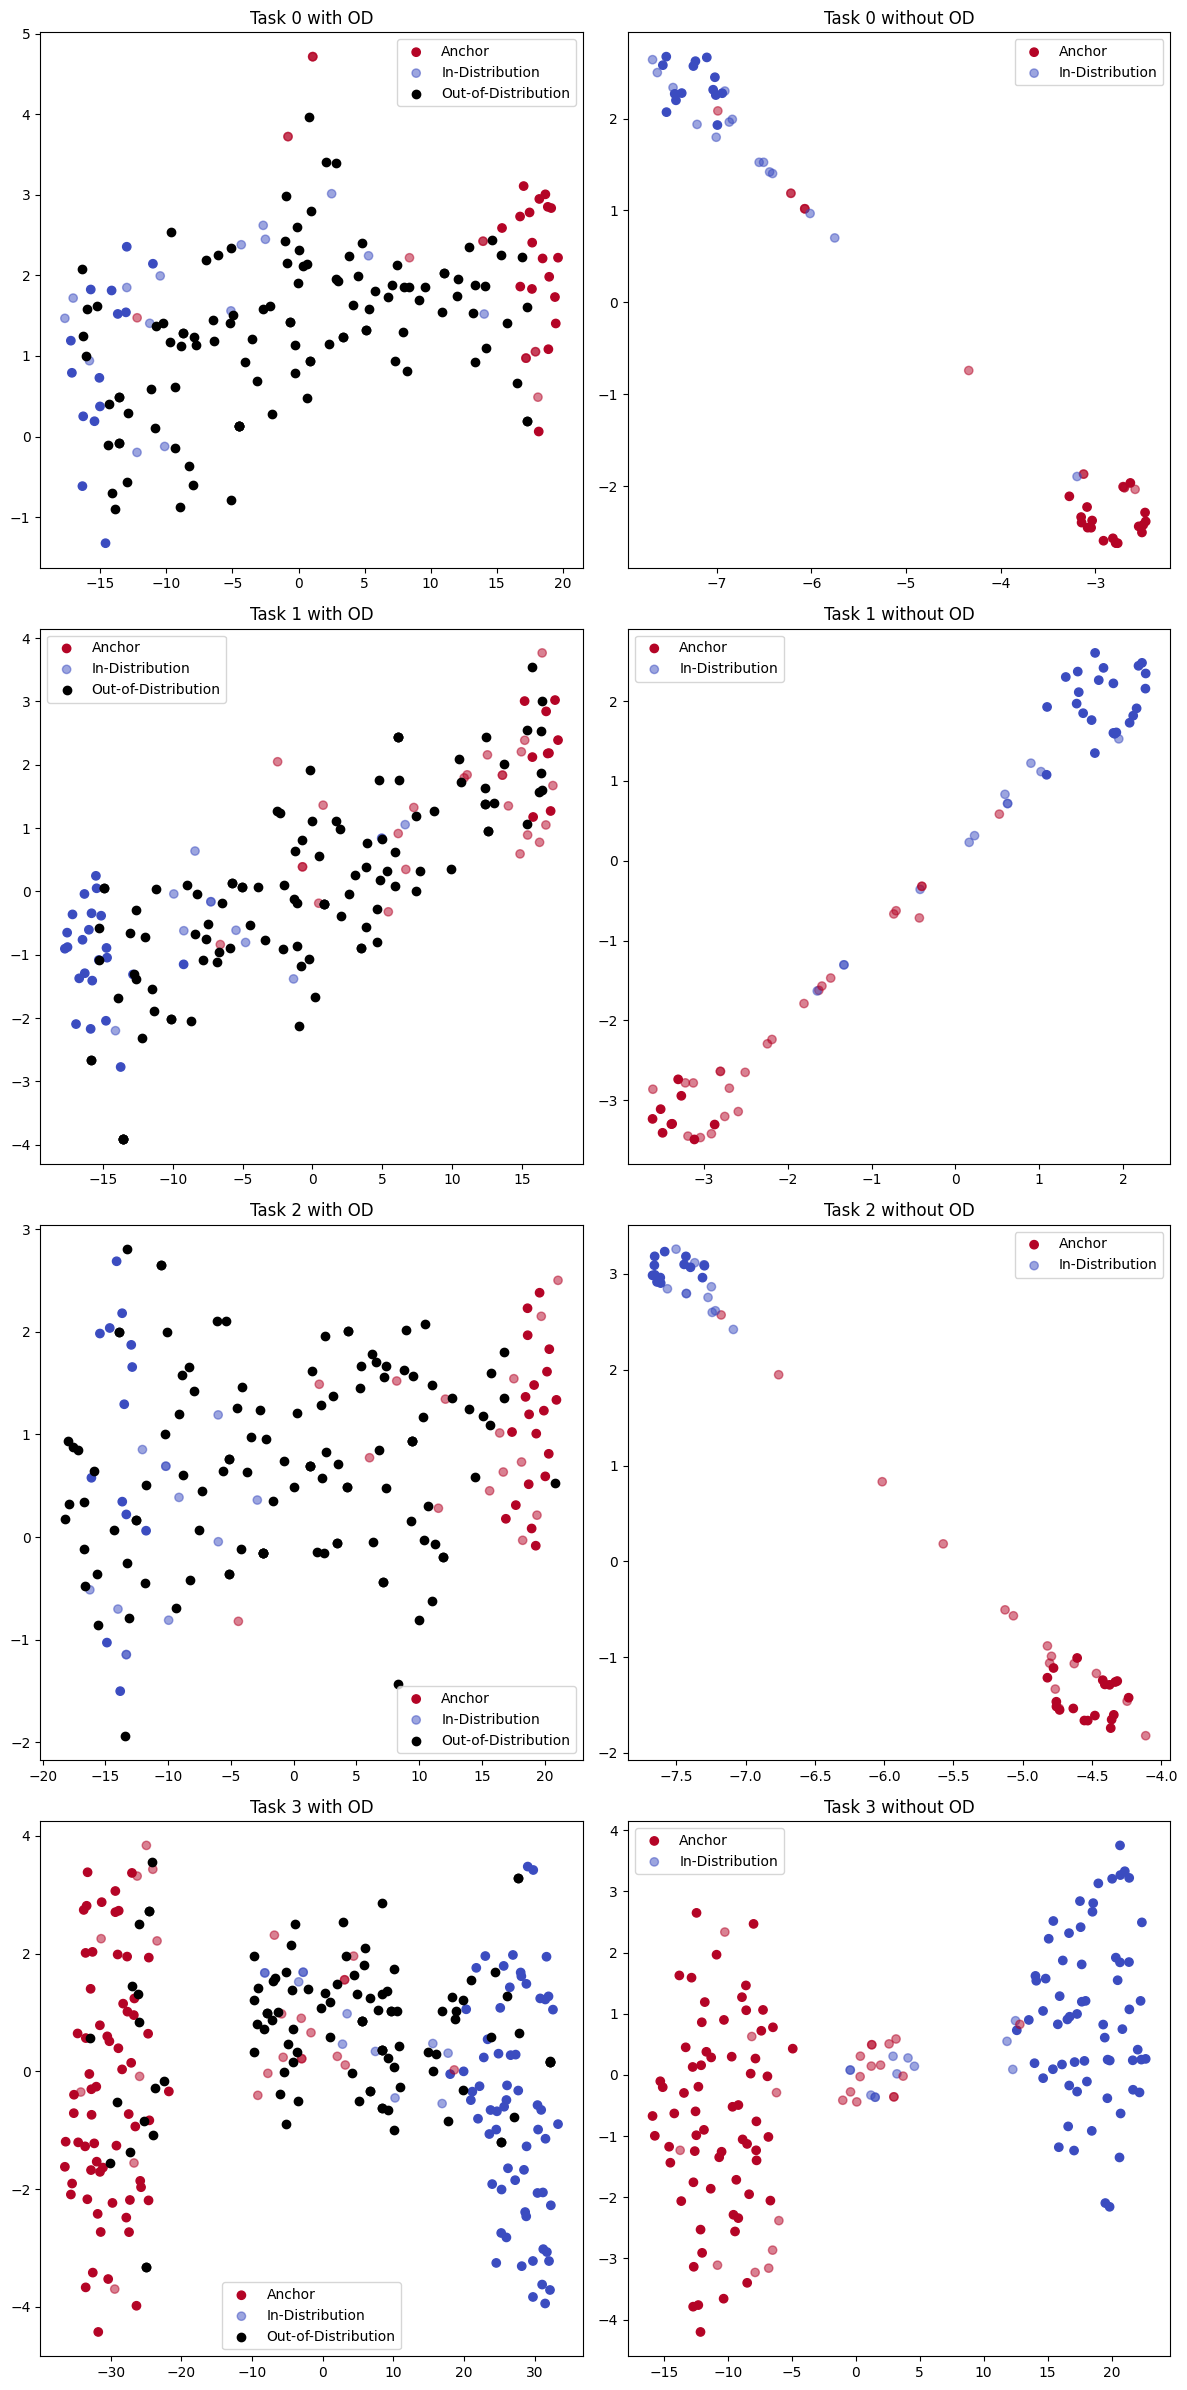

In [12]:
# Determine the grid size for the subplots
num_tasks = task_id + 1
cols = 2  # two columns for with and without OD
rows = num_tasks

# Create a large figure to hold all subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 6 * rows))

for t in range(num_tasks):
    data_dict = fleet.agents[0].get_format_viz_data(t)
    print('task', t, 'num anchors', len(data_dict['anchor'][0]), 'num id', len(data_dict['ID'][0]), 'num od', len(data_dict['OD'][0]))

    # Partial function for transform
    transform = partial(contrastive_transform, fleet.agents[0].net, t)

    # Process and plot data with OD
    data_dict_with_od = apply_transform_to_data_dict(data_dict, transform)
    data_dict_with_od = combined_tsne_transform(data_dict_with_od)
    plot_data(data_dict_with_od, ax=axs[t, 0])
    axs[t, 0].set_title(f'Task {t} with OD')

    # Remove OD data, process and plot data without OD
    if 'OD' in data_dict:
        del data_dict['OD']
    data_dict_without_od = apply_transform_to_data_dict(data_dict, transform)
    data_dict_without_od = combined_tsne_transform(data_dict_without_od)
    plot_data(data_dict_without_od, ax=axs[t, 1])
    axs[t, 1].set_title(f'Task {t} without OD')

# Adjust layout and save the entire figure
plt.tight_layout()
fig.savefig("all_tasks_plots.png", dpi=300)

task 0 num anchors 32 num id 30 num od 110
task 1 num anchors 32 num id 36 num od 104
task 2 num anchors 32 num id 27 num od 113
task 3 num anchors 128 num id 36 num od 104


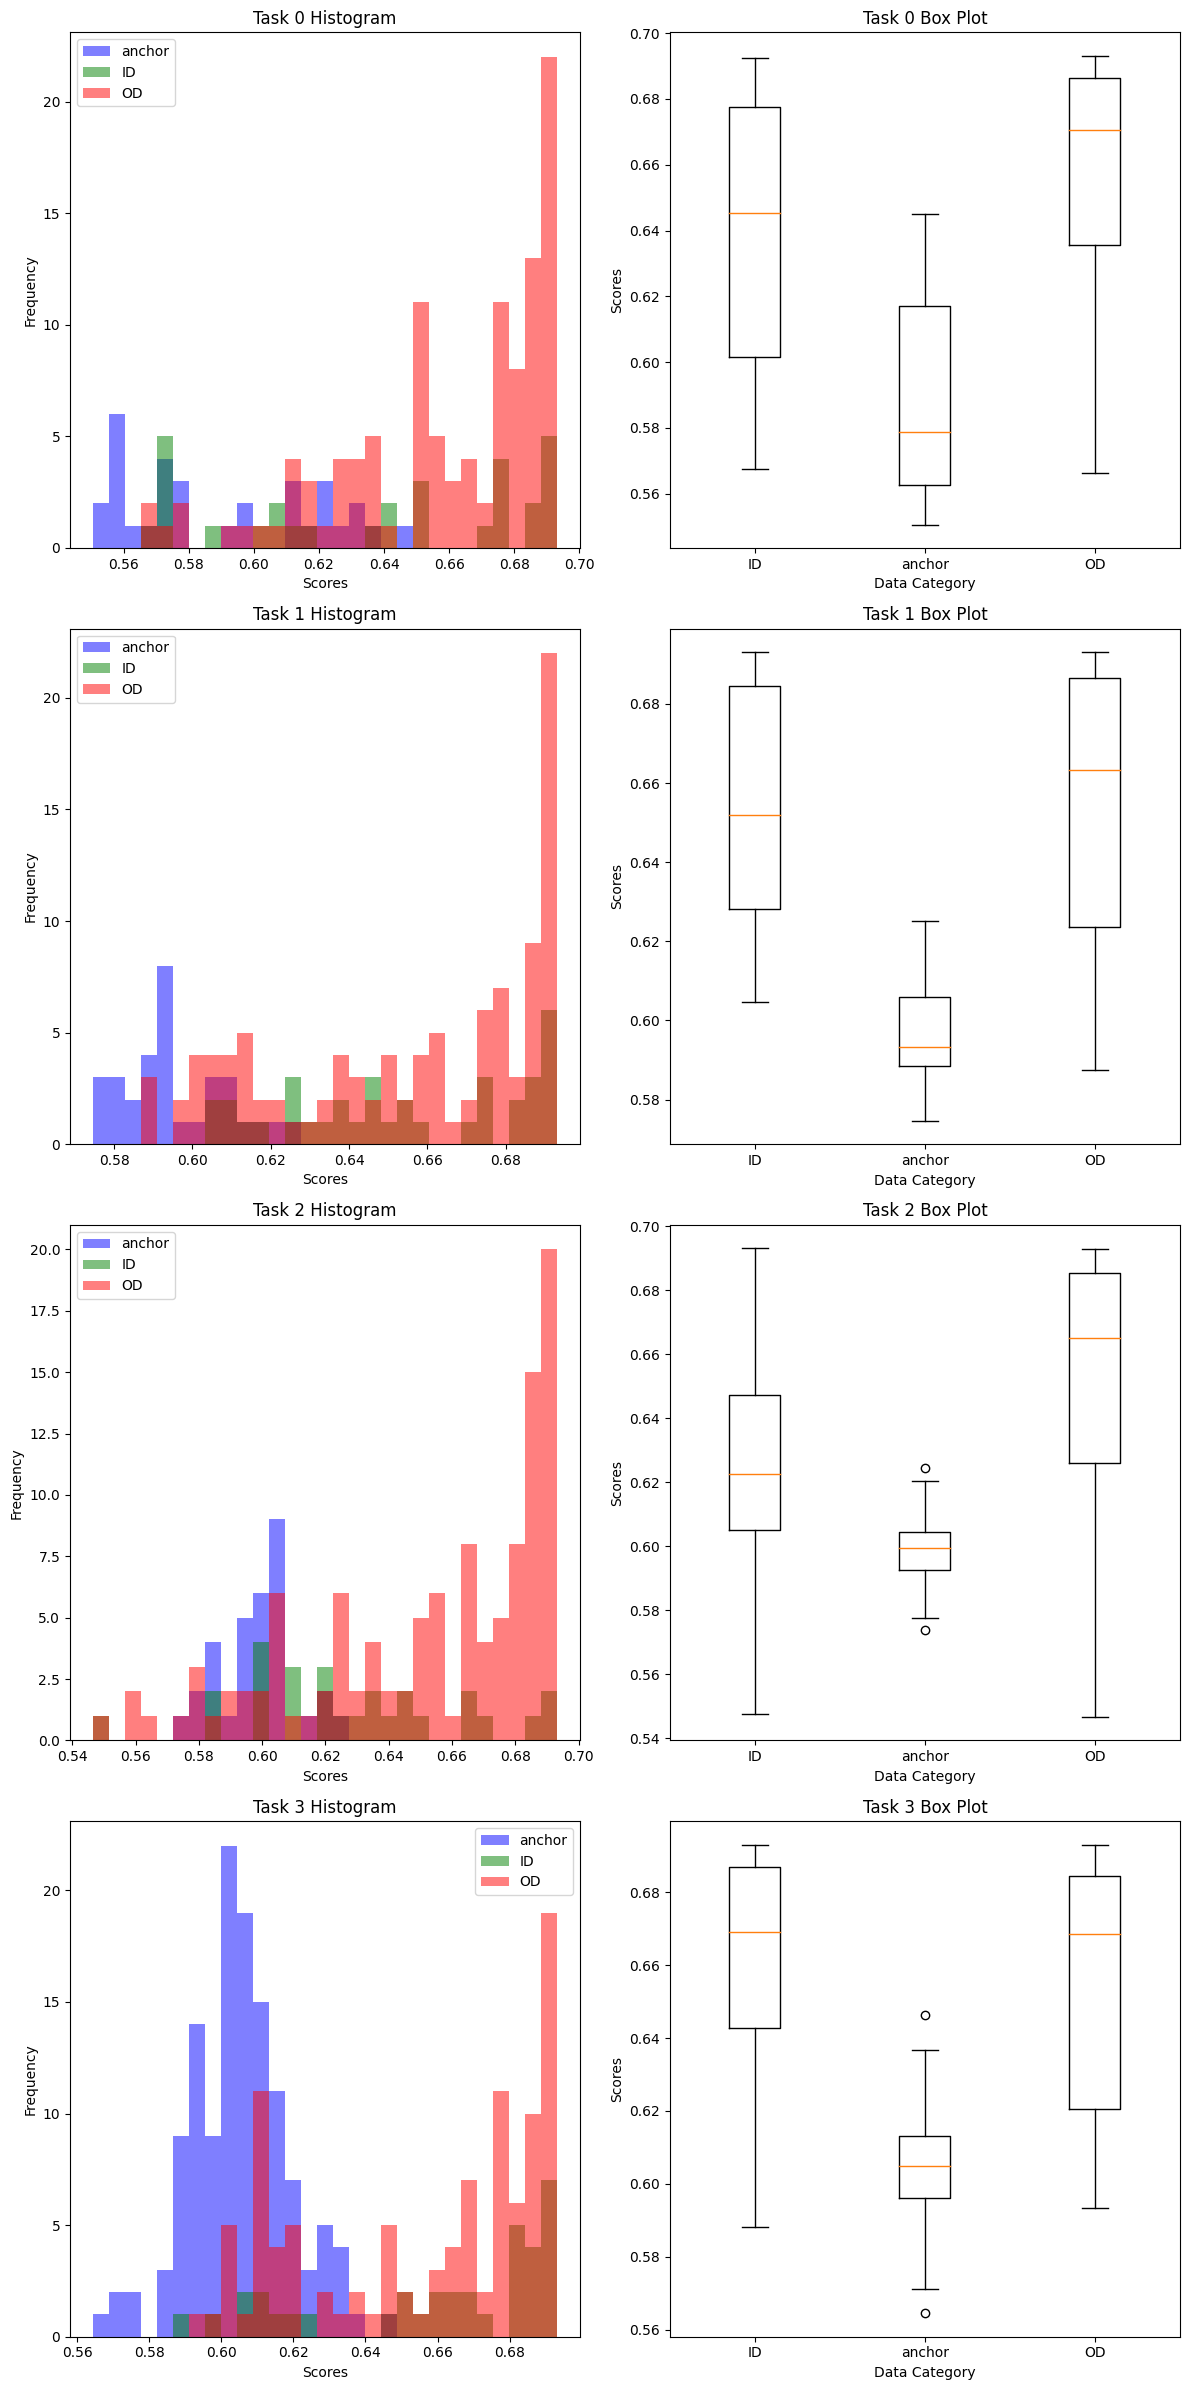

In [13]:
import matplotlib.pyplot as plt
from functools import partial

# Number of tasks times two subplots (histogram and box plot) per task
total_subplots = 2 * (task_id + 1)
fig, axs = plt.subplots(task_id + 1, 2, figsize=(12, 6 * (task_id + 1)))

for t in range(task_id + 1):
    data_dict = fleet.agents[0].get_format_viz_data(t)
    print('task', t, 'num anchors', len(data_dict['anchor'][0]), 'num id', len(data_dict['ID'][0]), 'num od', len(data_dict['OD'][0]))

    computer = partial(prefilter_computer, fleet.agents[0].net, task_id=t, computer_type='cross_entropy')

    # Plot histogram scores in the first subplot of the current row
    plot_scores(data_dict, computer, axs[t, 0])

    # Plot box plot scores in the second subplot of the current row
    plot_scores_box(data_dict, computer, axs[t, 1])

    # Set titles for subplots
    axs[t, 0].set_title(f'Task {t} Histogram')
    axs[t, 1].set_title(f'Task {t} Box Plot')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("all_tasks_hist.png", dpi=300)

# Optionally, display the figure
plt.show()

In [14]:
len(fleet.agents[0].agent.replay_buffers[0])

32